In [1]:
# import packages
from neuron import h, gui
from neuron.units import ms, mV, µm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Set up neuron type classes (pseudunipolar neuron and multipolar neuron)

In [295]:
# PseudoUnipolarNeuron Class (used for sensory neurons)
class PseudoUnipolarNeuron():
    name = 'PseudoUnipolarNeuron'

    # initializations (for morphology and biophysics)
    def __init__(self, soma_len=12.6157, soma_diam=12.6157, dendrite_len=200, dendrite_diam=1, axon_len=50, axon_diam = 2, el="default"):
        self._morphology(soma_len, soma_diam, dendrite_len, dendrite_diam, axon_len, axon_diam)
        #self.all = self.soma.wholetree()
        self.all = self.soma.wholetree()
        self._biophysics(el)
 
    # sets up the neuron components and connect them
    def _morphology(self, soma_len, soma_diam, dendrite_len, dendrite_diam, axon_len, axon_diam):
        self.soma = h.Section(name='soma')
        self.dendrite = h.Section(name='dendrite')
        self.axon = h.Section(name='axon')


        self.axon.connect(self.soma(1))
        self.dendrite.connect(self.soma(0))

        self.soma.L = soma_len
        self.soma.diam = soma_diam
        self.dendrite.L = dendrite_len
        self.dendrite.diam = dendrite_diam
        self.axon.L = axon_len
        self.axon.diam = axon_diam

    # set up the biophysics of the neuron
    def _biophysics(self, el):
        self.soma.insert('hh')
        self.dendrite.insert('hh')
        self.axon.insert('hh')

        if el != "default":
            for sec in self.soma:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.dendrite:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.axon:
                sec.hh.el = el

In [297]:
# MultipolarNeuron class (used for interneurons and motor neruons)
class MultipolarNeuron():
    name = 'MultipolarNeuron'

    # initializations
    def __init__(self, soma_len=12.6157, soma_diam=12.6157, dendrite1_len=200, dendrite1_diam=1, dendrite2_len=200, dendrite2_diam=1, dendrite3_len=200, dendrite3_diam=1, axon_len=50, axon_diam=2, el = "default"):
        self._morphology(soma_len, soma_diam, dendrite1_len, dendrite1_diam, dendrite2_len, dendrite2_diam, dendrite3_len, dendrite3_diam, axon_len)
        self.all = self.soma.wholetree()
        self._biophysics(el)
 
    # sets up structure and components of neurons and connects them
    def _morphology(self, soma_len, soma_diam, dendrite1_len, dendrite1_diam, dendrite2_len, dendrite2_diam, dendrite3_len, dendrite3_diam, axon_len):
        self.soma = h.Section(name='soma')
        self.dendrite1 = h.Section(name='dendrite')
        self.dendrite2 = h.Section(name='dendrite')
        self.dendrite3 = h.Section(name='dendrite')
        self.axon = h.Section(name='axon')

        self.dendrite1.connect(self.soma(0))
        self.dendrite2.connect(self.soma(0.01))
        self.dendrite3.connect(self.soma(0.02))

        self.axon.connect(self.soma(1))
        
        self.soma.L = soma_len
        self.soma.diam = soma_diam
        self.dendrite1.L = dendrite1_len
        self.dendrite1.diam = dendrite1_diam
        self.dendrite2.L = dendrite2_len
        self.dendrite2.diam = dendrite2_diam
        self.dendrite3.L = dendrite3_len
        self.dendrite3.diam = dendrite3_diam
        self.axon.L = axon_len

    # sets up the biophysics of the neurons (incorporates Hudgkin Huxley model)
    def _biophysics(self, el):
        self.soma.insert('hh')
        self.dendrite1.insert('hh')
        self.dendrite2.insert('hh')
        self.dendrite3.insert('hh')
        self.axon.insert('hh') 
        
        if el != "default":
            for sec in self.soma:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.dendrite1:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.dendrite2:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.dendrite3:
                sec.hh.el = el # reversal potential (this helps decide excitatory vs inhibitory PSPs)
            for sec in self.axon:
                sec.hh.el = el

In [4]:
# reset neuron topology as needed
for sec in h.allsec():
    h.delete_section(sec=sec)

### Test for Soma and Dendrite Action Potentials (of single PseudoUnipolarNeuron)

Text(0.5, 1.0, 'Soma and Dendrite Potentials')

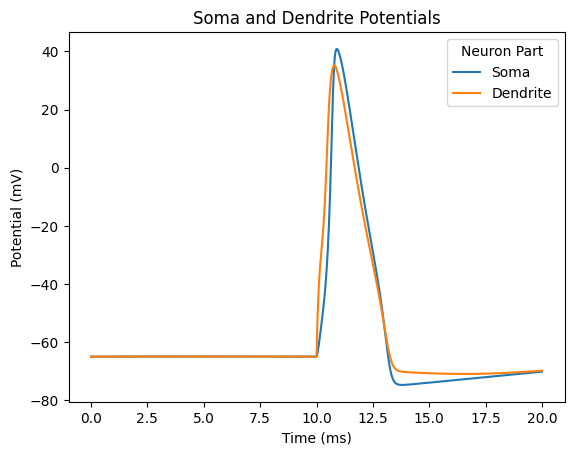

In [363]:
# create the pseudounipolar neuron
pun = PseudoUnipolarNeuron()

# make stimmulus
stimulus = h.NetStim()

# attach it to synapse in middle of first neuron's dendrite
syn_ = h.ExpSyn(pun.dendrite(0.5))

stimulus.number = 1
stimulus.start = 9
nc_stim = h.NetCon(stimulus, syn_)
nc_stim.delay = 1 * ms
nc_stim.delay = 1 * ms
nc_stim.weight[0] = 0.04

syn_.tau = 2 * ms

# Record the membrane potential
t = h.Vector().record(h._ref_t)
dend_v = h.Vector()
dend_v.record(pun.dendrite(0.5)._ref_v)
soma_v = h.Vector()
soma_v.record(pun.soma(0.5)._ref_v)

# Run the simulation
h.tstop = 20  # Simulation time in ms
h.run()

# Plot the results
sd_potentials_df = pd.DataFrame({'Time (ms)': t, 'Soma': soma_v, 'Dendrite': dend_v})
sd_pot_df = pd.melt(sd_potentials_df, id_vars = ('Time (ms)'), value_vars = ('Soma', 'Dendrite'), var_name='Neuron Part', value_name='Potential (mV)')
sns.lineplot(sd_pot_df, x='Time (ms)', y='Potential (mV)', hue='Neuron Part').set_title('Soma and Dendrite Potentials')

### Test for Soma, Dendrite and Axon Potentials (Single pseudounipolar neuron)

Text(0.5, 1.0, 'Soma, Dendrite and Axon Potentials')

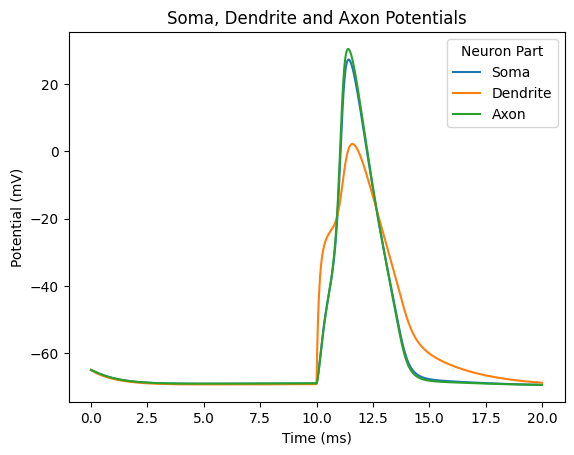

In [6]:
# set up pseudounipolar neuron
pun = PseudoUnipolarNeuron()

# make stimulus
stimulus = h.NetStim()

# attach it to synapse in middle of first neuron's dendrite
syn_ = h.ExpSyn(pun.dendrite(0.5))

stimulus.number = 1
stimulus.start = 9
nc_stim = h.NetCon(stimulus, syn_)
nc_stim.delay = 1 * ms
nc_stim.delay = 1 * ms
nc_stim.weight[0] = 0.04

syn_.tau = 2 * ms

# Record the membrane potential
t = h.Vector().record(h._ref_t)
dend_v = h.Vector()
dend_v.record(pun.dendrite(0.5)._ref_v)
soma_v = h.Vector()
soma_v.record(pun.soma(0.5)._ref_v)
axon_v = h.Vector()
axon_v.record(pun.axon(0.5)._ref_v)

# Run the simulation
h.tstop = 20  # Simulation time in ms
h.run()

# Plot the results
sd_potentials_df = pd.DataFrame({'Time (ms)': t, 'Soma': soma_v, 'Dendrite': dend_v, 'Axon':axon_v})
sd_pot_df = pd.melt(sd_potentials_df, id_vars = ('Time (ms)'), value_vars = ('Soma', 'Dendrite', 'Axon'), var_name='Neuron Part', value_name='Potential (mV)')
sns.lineplot(sd_pot_df, x='Time (ms)', y='Potential (mV)', hue='Neuron Part').set_title('Soma, Dendrite and Axon Potentials')

### Test Action Potential Propagation and Signalling Across Synapse for 2 Psuedounipolar Neurons

In [366]:
# set up the 2 pseudounipolar neurons and connect them to form a mini network
pun = PseudoUnipolarNeuron(el = -70)
pun2 = PseudoUnipolarNeuron(el = -70)
syns = []
netcons = []

syn = h.ExpSyn(pun2.dendrite(0.5))
nc = h.NetCon(pun.axon(1.0)._ref_v, syn, sec=pun.axon)
nc.weight[0] = 0.5 # 0.05
nc.delay = 5
netcons.append(nc)
syns.append(syn)

In [289]:
# make and administer stimulus
stimulus = h.NetStim()

# attach it to synapse in middle of first neuron's dendrite
syn_ = h.ExpSyn(pun.dendrite(0.5))

stimulus.number = 1
stimulus.start = 9
nc_stim = h.NetCon(stimulus, syn_)
nc_stim.delay = 1 * ms
nc_stim.delay = 1 * ms
nc_stim.weight[0] = 0.0025

syn_.tau = 2 * ms

In [290]:
# record voltage of the 2 neurons' somas
recording_cell = pun
recording_cell2 = pun2
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
soma2_v = h.Vector().record(recording_cell2.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
syn_i = h.Vector().record(syn_._ref_i)

In [291]:
# run simulation
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

In [292]:
# gather soma data into table for plotting
sd_2puns_df = pd.DataFrame({'Time (ms)': t, 'Soma': soma_v, 'Soma2':soma2_v})
sd_2puns_df = pd.melt(sd_2puns_df, id_vars = ('Time (ms)'), value_vars = ('Soma', 'Soma2'), var_name='Neuron Part', value_name='Potential (mV)')

Text(0.5, 1.0, 'Soma and Soma2 Potentials')

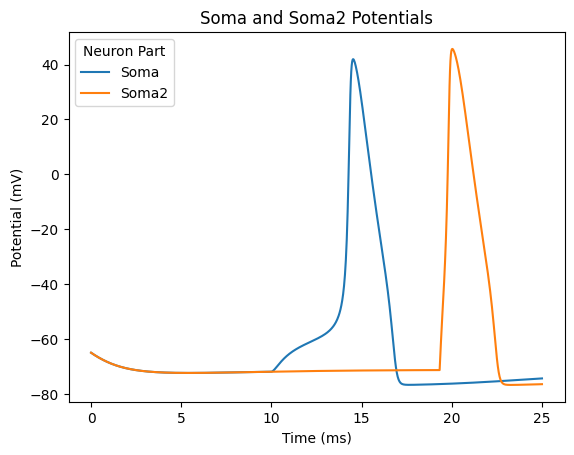

In [293]:
# plot the somas potentials
sns.lineplot(sd_2puns_df, x='Time (ms)', y='Potential (mV)', hue='Neuron Part').set_title('Soma and Soma2 Potentials')

### Patellar Reflex Test


(-85.0, 45.0)

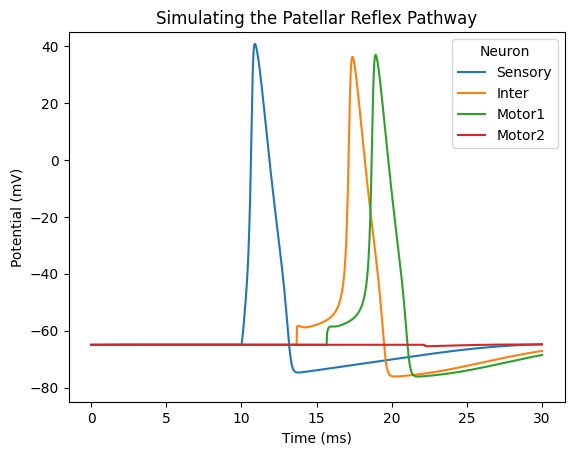

In [342]:
# function to simulate the patellar reflex (simplified model): uses 1 sensory neuron, 1 interneuron and 2 motor neurons (one receives EPSP from sensory neuron and the other receives IPSP from interneuron)
def simulate_patellar_reflex(stim_weight):
    # Set Up Neuron Network
    sensory_neuron = PseudoUnipolarNeuron()
    interneuron = MultipolarNeuron(soma_len=2, soma_diam=2, dendrite1_diam=1, dendrite1_len=1)
    motor_neuron_1 = MultipolarNeuron(soma_len=4, soma_diam=4, dendrite1_diam=1, dendrite1_len=1)
    motor_neuron_2 = MultipolarNeuron(soma_len=4, soma_diam=4, dendrite1_diam=1, dendrite1_len=1)
    syns = []
    netcons = []

    syn = h.ExpSyn(interneuron.dendrite1(0.5))
    nc = h.NetCon(sensory_neuron.axon(1.0)._ref_v, syn, sec=sensory_neuron.axon)
    nc.weight[0] = 1 # 0.05
    nc.delay = 3
    netcons.append(nc)
    syns.append(syn)

    syn = h.ExpSyn(motor_neuron_1.dendrite1(0.5))
    nc = h.NetCon(sensory_neuron.axon(1.0)._ref_v, syn, sec=sensory_neuron.axon)
    nc.weight[0] = 1 # 0.05 # strength of synapse connection
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

    syn = h.ExpSyn(motor_neuron_2.dendrite1(0.5))
    syn.e = -70
    nc = h.NetCon(interneuron.axon(1.0)._ref_v, syn, sec=interneuron.axon)
    nc.weight[0] = 1 # 0.05 # strength of synapse connection
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

    ## Inject Stimulus
    stimulus = h.NetStim()

    # attach it to synapse in middle of first neuron's dendrite
    syn_ = h.ExpSyn(sensory_neuron.dendrite(0.5))

    stimulus.number = 1
    stimulus.start = 9
    nc_stim = h.NetCon(stimulus, syn_)
    nc_stim.delay = 1 # ms
    nc_stim.delay = 1 # ms
    nc_stim.weight[0] = stim_weight

    syn_.tau = 2 * ms

    ## Set Up Recording
    sn_probe = sensory_neuron
    in_probe = interneuron
    mn1_probe = motor_neuron_1
    mn2_probe = motor_neuron_2
    sn_v = h.Vector().record(sn_probe.soma(0.5)._ref_v)
    in_v = h.Vector().record(in_probe.soma(0.5)._ref_v)
    mn1_v = h.Vector().record(mn1_probe.soma(0.5)._ref_v)
    mn2_v = h.Vector().record(mn2_probe.soma(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)
    syn_i = h.Vector().record(syn_._ref_i)

    ## Simulate
    h.finitialize(-65 * mV)
    h.continuerun(30 * ms)

    ## Plot
    patellar_df = pd.DataFrame({'Time (ms)': t, 'Sensory': sn_v, 'Inter':in_v, 'Motor1':mn1_v, 'Motor2':mn2_v})
    patellar_df = pd.melt(patellar_df, id_vars = ('Time (ms)'), value_vars = ('Sensory', 'Inter', 'Motor1', 'Motor2'), var_name='Neuron', value_name='Potential (mV)')
    return patellar_df

(-85.0, 45.0)

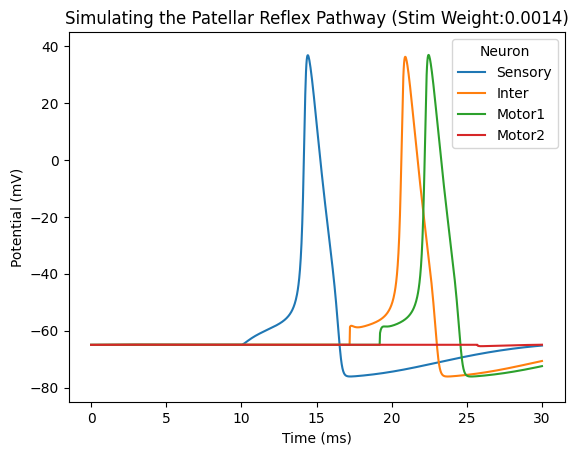

In [359]:
# simulate patellar reflex with stim_weight = 0.0014 (just enough to induce action potentials)
stim_weight = 0.0014
patellar_df = simulate_patellar_reflex(stim_weight)
sns.lineplot(patellar_df, x='Time (ms)', y='Potential (mV)', hue='Neuron').set_title('Simulating the Patellar Reflex Pathway (Stim Weight:'+str(stim_weight)+')')
plt.ylim(-85, 45)

(-85.0, 45.0)

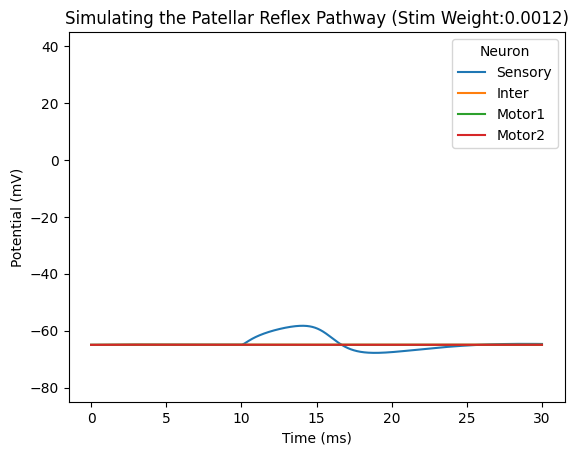

In [362]:
# simulate patellar reflex with stim_weight = 0.0012 (not enough to induce action potentials, only sensory neuron is slightly affected here)
stim_weight = 0.0012
patellar_df = simulate_patellar_reflex(stim_weight)
sns.lineplot(patellar_df, x='Time (ms)', y='Potential (mV)', hue='Neuron').set_title('Simulating the Patellar Reflex Pathway (Stim Weight:'+str(stim_weight)+')')
plt.ylim(-85, 45)